In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
import pickle
import os
from sklearn.decomposition import NMF, PCA
from sklearn.cluster import KMeans
from importlib import reload

import sys
sys.path.insert(1, '/Users/madisonthantu/Desktop/DREAM/t-recs')
from trecs.metrics import Measurement
from trecs.metrics import MSEMeasurement, InteractionSpread, InteractionSpread, InteractionSimilarity, RecSimilarity, RMSEMeasurement, InteractionMeasurement
from trecs.components import Users
import trecs.matrix_ops as mo
import src.globals as globals
import seaborn as sns

from wrapper.models.bubble import BubbleBurster
from src.utils import *
from src.plotting import plot_measurements 
from src.scoring_functions import cosine_sim, entropy, content_fairness, top_k_reranking, cosine_sim2
from wrapper.metrics.evaluation_metrics import *

random_state = np.random.seed(42)
plt.style.use("seaborn")

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

globals.initialize()

/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_76777/579812108.py:27: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


# RecommenderSystem on MovieLens 

In [2]:
n_attrs=20
max_iter=1000
n_clusters=10

In [3]:
score_fn = None #'cosine_sim' #'top_k_reranking'#'entropy' #'entropy' #'content_fairness' 
probabilistic = False
globals.ALPHA = 0.01 #10.0 #0.01 # 0.1 
alpha = globals.ALPHA

# User parameters
drift = 0.1
attention_exp=-0.8
retrain = True

if retrain:
    str_retrain = "retrainTrue"
else:
    str_retrain = "retrainFalse"

experiment_name = 'supplementary'
this_experiment = f"{score_fn}_{alpha}_{str_retrain}"

## Embeddings

In [4]:
binary_ratings_matrix = load_and_process_movielens(file_path='/Users/madisonthantu/Desktop/DREAM/data/ml-100k/u.data')

In [5]:
# Get user and item representations using NMF
user_representation, item_representation = create_embeddings(binary_ratings_matrix, n_attrs=n_attrs, max_iter=max_iter)

Loaded embeddings.


In [6]:
# Define topic clusters using NMF
item_cluster_ids, item_cluster_centers = get_clusters(item_representation.T, name='item', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)
user_cluster_ids, user_cluster_centers = get_clusters(user_representation, name='user', n_clusters=n_clusters, n_attrs=n_attrs, max_iter=max_iter)

Loaded clusters.
Loaded clusters.


### Model

In [7]:
num_users = user_representation.shape[0] #len(user_representation)
num_items = item_representation.shape[1]#len(item_representation)
print(f'Number of items: {num_items}')
print(f'Number of users: {num_users}')

users = Users(actual_user_profiles=user_representation, 
              repeat_interactions=False, 
              drift=drift,
              attention_exp=attention_exp)

Number of items: 1682
Number of users: 943


In [8]:
import math

user_item_cluster_mapping = user_topic_mapping(user_representation, item_cluster_centers) # TODO: Remove?
# Create user_pairs by pairing users only with others that are not in the same cluster
inter_cluster_user_to_topic_pairs, intra_cluster_user_to_topic_pairs = create_cluster_user_pairs(user_item_cluster_mapping)

assert(len(inter_cluster_user_to_topic_pairs) + len(intra_cluster_user_to_topic_pairs) == (math.factorial(num_users) / (math.factorial(2)*math.factorial(num_users-2)))), "Bug with creating user pairs"

In [9]:
inter_cluster_user_pairs, intra_cluster_user_pairs = create_cluster_user_pairs(user_cluster_ids)

assert(len(inter_cluster_user_pairs) + len(intra_cluster_user_pairs) == (math.factorial(num_users) / (math.factorial(2)*math.factorial(num_users-2)))), "Bug with creating user pairs"

In [10]:
mse = MSEMeasurement()
measurements = [
    InteractionMeasurement(),
    MSEMeasurement(),  
    InteractionSpread(),              
      
    InteractionSimilarity(pairs=inter_cluster_user_to_topic_pairs, name='inter_cluster_interaction_similarity_USER:TOPIC'), 
    InteractionSimilarity(pairs=intra_cluster_user_to_topic_pairs, name='intra_cluster_interaction_similarity_USER:TOPIC'), 
    RecSimilarity(pairs=inter_cluster_user_to_topic_pairs, name='inter_cluster_rec_similarity_USER:TOPIC'), 
    RecSimilarity(pairs=intra_cluster_user_to_topic_pairs, name='intra_cluster_rec_similarity_USER:TOPIC'), 
    
    InteractionSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_interaction_similarity_USER:TOPIC'), 
    InteractionSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_interaction_similarity_USER:TOPIC'), 
    RecSimilarity(pairs=inter_cluster_user_pairs, name='inter_cluster_rec_similarity_USER:TOPIC'), 
    RecSimilarity(pairs=intra_cluster_user_pairs, name='intra_cluster_rec_similarity_USER:TOPIC'), 
    # UserMSEMeasurement(),
    # SerendipityMetric(), 
    # DiversityMetric(), 
    # NoveltyMetric(),
    # RecallMeasurement(),
    # MeanNumberOfTopics(),
    IntraClusterCosineSim(mapping=user_item_cluster_mapping, n_clusters=n_clusters, name='intra_user_to_topic_cluster_cos_sim'),
    IntraClusterCosineSim(mapping=user_cluster_ids, n_clusters=n_clusters, name='intra_user_cluster_cos_sim'),
    MeanDistanceFromCentroid(user_cluster_ids, user_cluster_centers, name='user_cluster_avg_distance_from_centroid'),
]

In [11]:
# Model
config = {
    'actual_user_representation': users,
    'actual_item_representation': item_representation,
    'item_topics': item_cluster_ids,
    'num_attributes': n_attrs,
    'num_items_per_iter': 10,
    'seed': 42,
    'record_base_state': True,
}

model_name='myopic'
requires_alpha = False

if score_fn:
    if score_fn == 'cosine_sim2':
        config['score_fn'] = cosine_sim2
        requires_alpha = True
    elif score_fn == 'cosine_sim':
        config['score_fn'] = cosine_sim
        requires_alpha = True
    elif score_fn == 'entropy':
        config['score_fn'] = entropy
        requires_alpha = True
    elif score_fn == 'content_fairness':
        config['score_fn'] = content_fairness
    elif score_fn == 'top_k_reranking':
        config['score_fn'] = top_k_reranking          
    else:
        raise Exception('Given score function does not exist.')
    model_name = score_fn
    # assert(config['score_fn'] == cosine_sim2)

if probabilistic:
    config['probabilistic_recommendations'] = True
    model_name += '_prob'

In [12]:
import src
reload(src)
reload(src.scoring_functions)
from src.scoring_functions import *

In [13]:
model = BubbleBurster(**config)

model.add_metrics(*measurements)

## Simulation

In [14]:
# Fair Model
train_timesteps=10
model.startup_and_train(timesteps=train_timesteps)

100%|██████████| 10/10 [00:40<00:00,  4.04s/it]


In [15]:
run_timesteps=100
model.run(timesteps=run_timesteps, train_between_steps=retrain)

100%|██████████| 100/100 [18:22<00:00, 11.02s/it]


In [16]:
def create_measurements_df(model, model_name, train_timesteps, file_path):
    measurements = model.get_measurements()
    df = pd.DataFrame(measurements)
    df['state'] = 'train' # makes it easier to later understand which part was training
    df.loc[df['timesteps'] > train_timesteps, 'state'] = 'run'
    df['model'] = model_name
    
    return df

In [16]:
# import src
# reload(src.utils)
# from src.utils import *
    
# # Determine file name based on parameter values
# parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
# if requires_alpha:
#     parameters += f'_{alpha}Lambda'

# # Save actual user preferences
# final_preferences_dir = f'artefacts/{experiment_name}/final_preferences/'
# file_prefix = f'{model_name}_final_preferences'
# final_preferences_path = final_preferences_dir + file_prefix + parameters + '.npy'
# np.save(final_preferences_path, model.users.actual_user_profiles.value, allow_pickle=True)

# # Save measurements
# measurements_dir = f'artefacts/{experiment_name}/measurements/'
# file_prefix = f'{model_name}_measurements'

# measurements_path = measurements_dir + file_prefix + parameters + '.csv'
# # np.set_printoptions(threshold=sys.maxsize)
# measurements_df = create_measurements_df(model, model_name, train_timesteps, measurements_path)
# # measurements_df['interaction_histogram'] = measurements_df['interaction_histogram'].tolist()

# # saving interaction histogram
# path_interaction_histogram = f'{measurements_dir}/interaction_histograms/{model_name}_interaction_histogram{parameters}.csv'
# interaction_hist = measurements_df['interaction_histogram'].copy()
# interaction_hist[0] = np.repeat(np.nan, interaction_hist[1].shape[0], axis=0)
# interaction_hist = np.stack(interaction_hist.values)
# test = pd.DataFrame(interaction_hist)
# test.to_csv(path_interaction_histogram, index=False)

# # saving use_mse histogram
# path_user_mse_histogram = f'{measurements_dir}/mse_histograms/{model_name}_user_mse_histogram{parameters}.csv'
# user_mse = measurements_df['user_mse'].copy()
# user_mse = np.stack(user_mse.values)
# test = pd.DataFrame(user_mse.T)
# test['clusterID'] = user_cluster_ids
# test.to_csv(path_user_mse_histogram, index=False)
# # saving all measurements
# measurements_df.to_csv(measurements_path, index=False)
# print('Measurements saved.')

In [17]:
# import src
# reload(src.utils)
# from src.utils import *
    
# # Determine file name based on parameter values
# parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
# if requires_alpha:
#     parameters += f'_{alpha}Lambda'

# # Save actual user preferences
# # final_preferences_dir = f'artefacts/no_train_between_runs/{experiment_name}/final_preferences/'
# # file_prefix = f'{model_name}_final_preferences'
# # final_preferences_path = final_preferences_dir + file_prefix + parameters + '.npy'
# # np.save(final_preferences_path, model.users.actual_user_profiles.value, allow_pickle=True)

# # Save measurements
# measurements_dir = f'artefacts/no_train_between_runs/{experiment_name}/measurements/'
# file_prefix = f'{model_name}_measurements'

# measurements_path = measurements_dir + file_prefix + parameters + '.csv'
# # np.set_printoptions(threshold=sys.maxsize)
# measurements_df = create_measurements_df(model, model_name, train_timesteps, measurements_path)
# # measurements_df['interaction_histogram'] = measurements_df['interaction_histogram'].tolist()

# # saving interaction histogram
# path_interaction_histogram = f'{measurements_dir}/interaction_histograms/{model_name}_interaction_histogram{parameters}.csv'
# interaction_hist = measurements_df['interaction_histogram'].copy()
# interaction_hist[0] = np.repeat(np.nan, interaction_hist[1].shape[0], axis=0)
# interaction_hist = np.stack(interaction_hist.values)
# test = pd.DataFrame(interaction_hist)
# test.to_csv(path_interaction_histogram, index=False)

# # saving use_mse histogram
# path_user_mse_histogram = f'{measurements_dir}/mse_histograms/{model_name}_user_mse_histogram{parameters}.csv'
# user_mse = measurements_df['user_mse'].copy()
# user_mse = np.stack(user_mse.values)
# test = pd.DataFrame(user_mse.T)
# test['clusterID'] = user_cluster_ids
# test.to_csv(path_user_mse_histogram, index=False)
# # saving all measurements
# measurements_df.to_csv(measurements_path, index=False)
# print('Measurements saved.')

In [18]:
import src
reload(src.utils)
from src.utils import *

if retrain:
    # Determine file name based on parameter values
    parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
    if requires_alpha:
        parameters += f'_{alpha}Lambda'

    # Save measurements
    measurements_dir = f'artefacts/{experiment_name}/measurements/'
    file_prefix = f'{model_name}_measurements'

    measurements_path = measurements_dir + file_prefix + parameters + '.csv'
    # np.set_printoptions(threshold=sys.maxsize)
    measurements_df = create_measurements_df(model, model_name, train_timesteps, measurements_path)
    # measurements_df['interaction_histogram'] = measurements_df['interaction_histogram'].tolist()

    # saving interaction histogram
    path_interaction_histogram = f'{measurements_dir}/interaction_histograms/{model_name}_interaction_histogram{parameters}.csv'
    interaction_hist = measurements_df['interaction_histogram'].copy()
    interaction_hist[0] = np.repeat(np.nan, interaction_hist[1].shape[0], axis=0)
    interaction_hist = np.stack(interaction_hist.values)
    test = pd.DataFrame(interaction_hist)
    test.to_csv(path_interaction_histogram, index=False)

    # # saving use_mse histogram
    # path_user_mse_histogram = f'{measurements_dir}/mse_histograms/{model_name}_user_mse_histogram{parameters}.csv'
    # user_mse = measurements_df['user_mse'].copy()
    # user_mse = np.stack(user_mse.values)
    # test = pd.DataFrame(user_mse.T)
    # test['clusterID'] = user_cluster_ids
    # test.to_csv(path_user_mse_histogram, index=False)
    # saving all measurements
    measurements_df.to_csv(measurements_path, index=False)
    print('Measurements saved.')
    
elif not retrain:    
    # Determine file name based on parameter values
    parameters = f'_{train_timesteps}trainTimesteps_{run_timesteps}runTimesteps_{n_attrs}nAttrs_{n_clusters}nClusters_{drift}Drift_{attention_exp}AttentionExp'
    if requires_alpha:
        parameters += f'_{alpha}Lambda'

    # Save measurements
    measurements_dir = f'artefacts/no_train_between_runs/{experiment_name}/measurements/'
    file_prefix = f'{model_name}_measurements'

    measurements_path = measurements_dir + file_prefix + parameters + '.csv'
    # np.set_printoptions(threshold=sys.maxsize)
    measurements_df = create_measurements_df(model, model_name, train_timesteps, measurements_path)
    # measurements_df['interaction_histogram'] = measurements_df['interaction_histogram'].tolist()

    # saving interaction histogram
    path_interaction_histogram = f'{measurements_dir}/interaction_histograms/{model_name}_interaction_histogram{parameters}.csv'
    interaction_hist = measurements_df['interaction_histogram'].copy()
    interaction_hist[0] = np.repeat(np.nan, interaction_hist[1].shape[0], axis=0)
    interaction_hist = np.stack(interaction_hist.values)
    test = pd.DataFrame(interaction_hist)
    test.to_csv(path_interaction_histogram, index=False)

    # # saving use_mse histogram
    # path_user_mse_histogram = f'{measurements_dir}/mse_histograms/{model_name}_user_mse_histogram{parameters}.csv'
    # user_mse = measurements_df['user_mse'].copy()
    # user_mse = np.stack(user_mse.values)
    # test = pd.DataFrame(user_mse.T)
    # test['clusterID'] = user_cluster_ids
    # test.to_csv(path_user_mse_histogram, index=False)
    # saving all measurements
    measurements_df.to_csv(measurements_path, index=False)
    print('Measurements saved.')
    
else:
    assert(0), "ERROR"

Measurements saved.


In [19]:
measurements_path

'artefacts/supplementary/measurements/myopic_measurements_10trainTimesteps_100runTimesteps_20nAttrs_10nClusters_0.1Drift_-0.8AttentionExp.csv'

In [28]:
# Create df for parameters
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])

In [29]:
print(measurements_df.columns)

def plot_measurements(dfs, parameters_df, ignored_train_ts=0):
    fig, ax = plt.subplots(5, 2, figsize=(15, 15))
    fig.tight_layout(pad=5.0)
    colors = plt.get_cmap('tab10')

    # plot rec_similarity with timesteps on x axis
    legend_lines, legend_names = [], []
    for i, df in enumerate(dfs):
        ts = df['timesteps'][ignored_train_ts:]
        name = parameters_df.loc[i, 'model_name']
        if not np.isnan(parameters_df.loc[i, 'Lambda']):
            name += f" (Lambda: {parameters_df.loc[i, 'Lambda']})"
        legend_names.append(name)
        
        line, = ax[0,0].plot(ts, df['mse'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
        ax[0, 0].set_title('Mean Squared Error')
        ax[0, 0].set_ylabel('MSE')
        # ax[0,1].plot(ts, df['user_mse'], label=name)
        if 'interaction_spread' in df.columns:
            ax[0,1].plot(ts, df['interaction_spread'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[0,1].set_title('Interaction Spread')
            ax[0,1].set_ylabel('Jaccard Similarity')
    
        if 'inter_cluster_interaction_similarity_USER:TOPIC' in df.columns:
            ax[1,0].plot(ts, df['inter_cluster_interaction_similarity_USER:TOPIC'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[1,0].set_title('inter_cluster_interaction_similarity_USER:TOPIC')
            ax[1,0].set_ylabel('Jaccard Similarity')
        if 'intra_cluster_interaction_similarity_USER:TOPIC' in df.columns:
            ax[1,1].plot(ts, df['intra_cluster_interaction_similarity_USER:TOPIC'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[1,1].set_title('intra_cluster_interaction_similarity_USER:TOPIC')
            ax[1,1].set_ylabel('Jaccard Similarity')

        if 'inter_cluster_rec_similarity_USER:TOPIC' in df.columns:
            ax[2,0].plot(ts, df['inter_cluster_rec_similarity_USER:TOPIC'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[2,0].set_title('inter_cluster_rec_similarity_USER:TOPIC')
            ax[2,0].set_ylabel('Jaccard Similarity')
        if 'intra_cluster_rec_similarity_USER:TOPIC' in df.columns:
            ax[2,1].plot(ts, df['intra_cluster_rec_similarity_USER:TOPIC'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[2,1].set_title('intra_cluster_rec_similarity_USER:TOPIC')
            ax[2,1].set_ylabel('Jaccard Similarity')

        if 'avg_intra_user_to_topic_cluster_cos_sim' in df.columns:
            ax[3,0].plot(ts, df['avg_intra_user_to_topic_cluster_cos_sim'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[3,0].set_title('avg_intra_user_to_topic_cluster_cos_sim')
            ax[3,0].set_ylabel('cos sim')
        if 'avg_intra_user_cluster_cos_sim' in df.columns:
            ax[3,1].plot(ts, df['avg_intra_user_cluster_cos_sim'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[3,1].set_title('avg_intra_user_cluster_cos_sim')
            ax[3,1].set_ylabel('cos sim')
            
        if 'avg_user_cluster_avg_distance_from_centroid' in df.columns:
            ax[4,0].plot(ts, df['avg_user_cluster_avg_distance_from_centroid'][ignored_train_ts:], label=name, alpha=0.5, color=colors(i))
            ax[4,0].set_title('avg_user_cluster_avg_distance_from_centroid')
            ax[4,0].set_ylabel('distance')
        
        
        legend_lines.append(line)

    for a in ax:
        for b in a:
            b.set_xlabel('Timestep')

    fig.legend(legend_lines,
               legend_names,
               loc='upper center',
               fontsize=12,
               frameon=False,
               ncol=5,
               bbox_to_anchor=(.5, 1.02))


Index(['interaction_histogram', 'mse', 'interaction_spread',
       'inter_cluster_interaction_similarity_USER:TOPIC',
       'intra_cluster_interaction_similarity_USER:TOPIC',
       'inter_cluster_rec_similarity_USER:TOPIC',
       'intra_cluster_rec_similarity_USER:TOPIC',
       'intra_user_to_topic_cluster_cos_sim', 'intra_user_cluster_cos_sim',
       'user_cluster_avg_distance_from_centroid', 'timesteps', 'state',
       'model'],
      dtype='object')


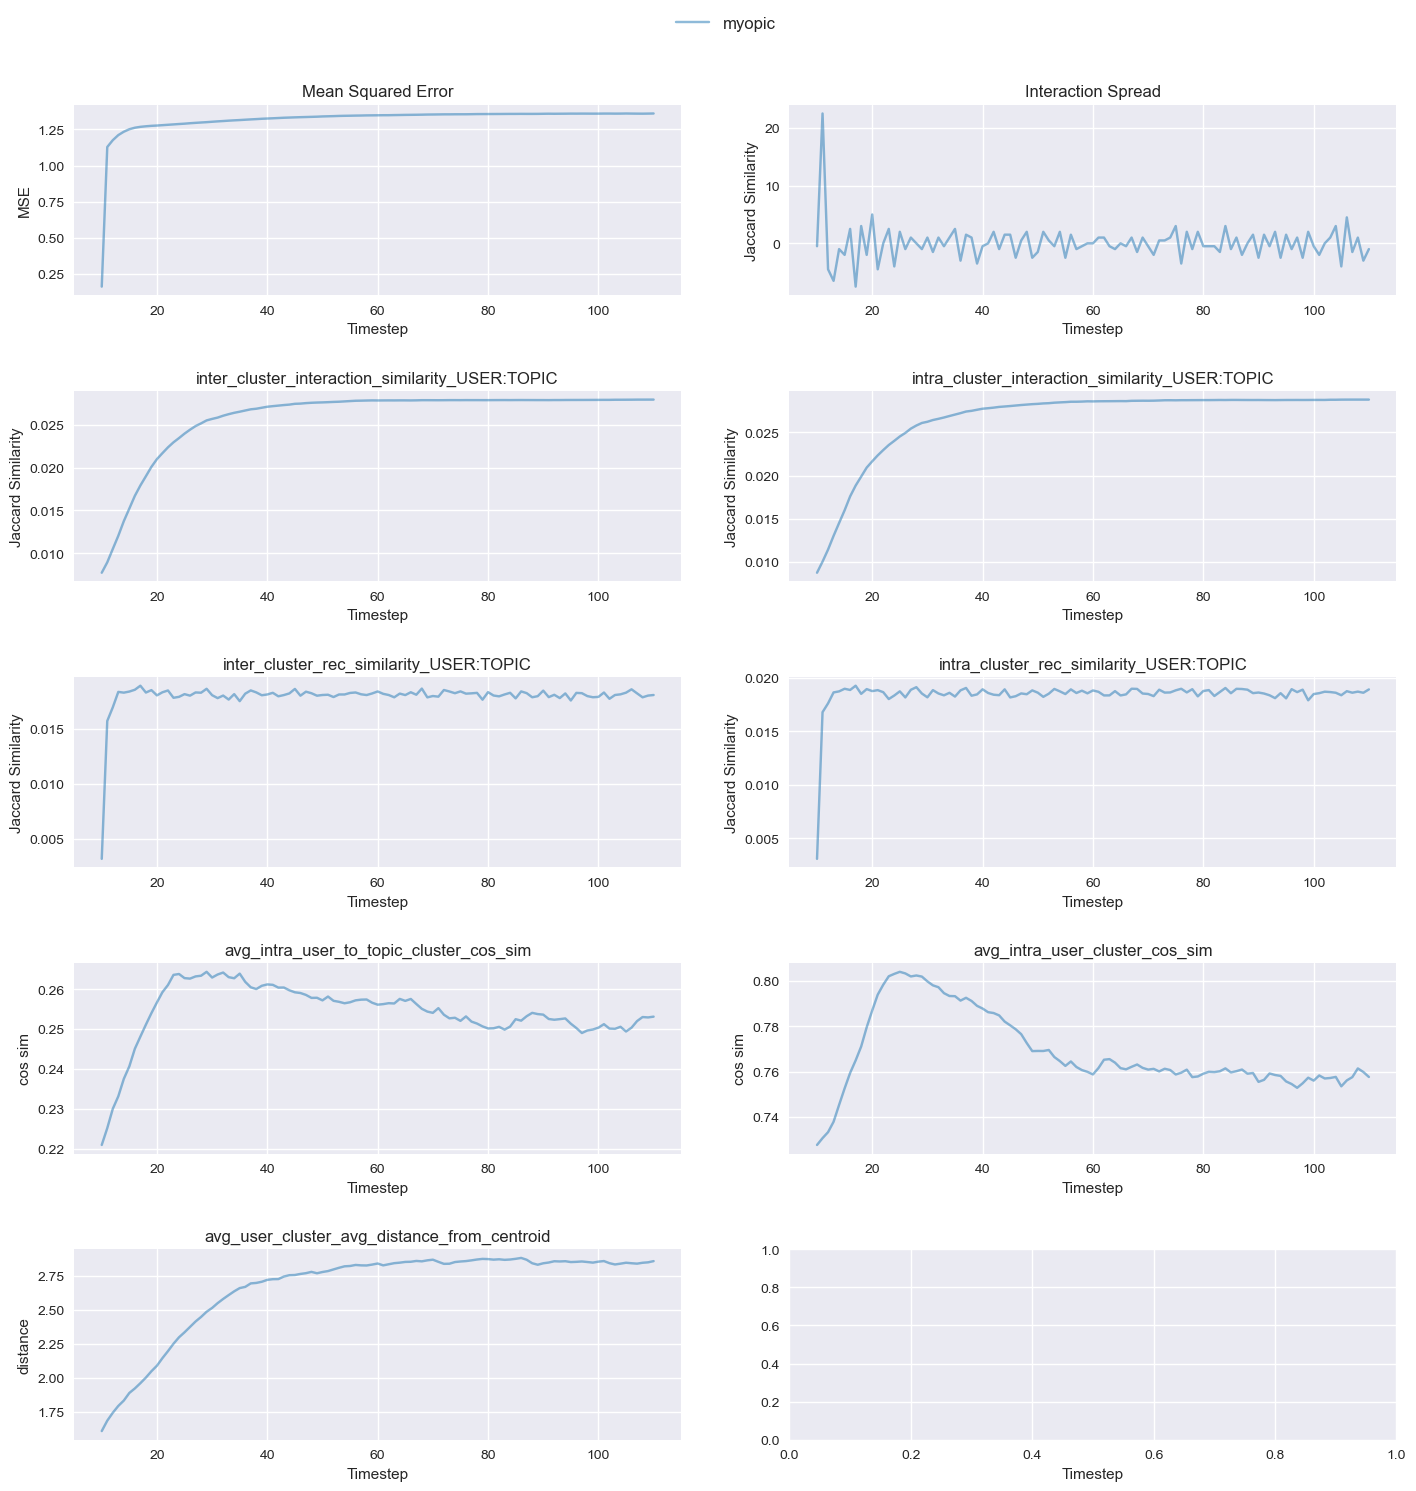

In [30]:
mean_cos_sim_user_cluster = [np.mean(x) for x in measurements_df['intra_user_cluster_cos_sim'].to_numpy()]
measurements_df['avg_intra_user_cluster_cos_sim'] = mean_cos_sim_user_cluster

mean_centroid_dist = [np.mean(x) for x in measurements_df['user_cluster_avg_distance_from_centroid'].to_numpy()]
measurements_df['avg_user_cluster_avg_distance_from_centroid'] = mean_centroid_dist

mean_cos_sim_user_topic = [np.mean(x) for x in measurements_df['intra_user_to_topic_cluster_cos_sim'].to_numpy()]
measurements_df['avg_intra_user_to_topic_cluster_cos_sim'] = mean_cos_sim_user_topic

plot_measurements([measurements_df], parameters_df, ignored_train_ts=10)

In [27]:
measurements_df

,interaction_histogram,mse,interaction_spread,inter_cluster_interaction_similarity_USER:TOPIC,intra_cluster_interaction_similarity_USER:TOPIC,inter_cluster_rec_similarity_USER:TOPIC,intra_cluster_rec_similarity_USER:TOPIC,intra_user_to_topic_cluster_cos_sim,intra_user_cluster_cos_sim,user_cluster_avg_distance_from_centroid,timesteps,state,model
0,None,0.090065,NaN,NaN,NaN,NaN,NaN,"[[0.7495802648524799], [0.0], [0.0], [0.0], [0...","[[0.2874645363027275], [0.7441788402482024], [...","[[0.26933535594760927], [0.7845332174664591], ...",0,train,myopic
1,"[6.0, 0.0, 1.0, 3.0, 2.0, 1.0, 5.0, 1.0, 4.0, ...",0.098476,-939.0,0.001331,0.001594,0.003175,0.003165,"[[0.7659637617751375], [0.0], [0.0], [0.0], [0...","[[0.3104807106899592], [0.7425032838771829], [...","[[0.26537659769668703], [0.78948245334992], [0...",1,train,myopic
2,"[1.0, 1.0, 1.0, 2.0, 0.0, 0.0, 2.0, 1.0, 2.0, ...",0.106020,-0.5,0.001663,0.002103,0.003099,0.003125,"[[0.7779340713985734], [0.0], [0.0], [0.0], [0...","[[0.3313961986913708], [0.7399097261811941], [...","[[0.2621794557173683], [0.801998054347763], [0...",2,train,myopic
3,"[2.0, 0.0, 2.0, 1.0, 1.0, 1.0, 4.0, 1.0, 2.0, ...",0.113727,-0.5,0.002328,0.002829,0.003147,0.003111,"[[0.8000996978815282], [0.0], [0.0], [0.0], [0...","[[0.3551244334753779], [0.7398603865718023], [...","[[0.2588165329580856], [0.8176387854824965], [...",3,train,myopic
4,"[2.0, 2.0, 3.0, 1.0, 0.0, 0.0, 2.0, 3.0, 1.0, ...",0.121468,0.0,0.003000,0.003665,0.003133,0.003121,"[[0.8159651905190407], [0.0], [0.0], [0.0], [0...","[[0.3771906941056413], [0.7407466895781787], [...","[[0.2560685819134272], [0.8376336651434627], [...",4,train,myopic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,"[0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...",1.358930,4.5,0.027928,0.028794,0.018586,0.018747,"[[0.9038868682922877], [0.0], [0.0], [0.0], [0...","[[0.7607867421878769], [0.8122291152035712], [...","[[0.27319222930086623], [1.3996607636424832], ...",106,run,myopic
107,"[3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 1.0, 2.0, ...",1.358508,-1.5,0.027935,0.028795,0.018221,0.018605,"[[0.918698267201824], [0.0], [0.0], [0.0], [0....","[[0.7626220490210871], [0.8138131322082386], [...","[[0.2731832189279534], [1.4038249729053045], [...",107,run,myopic
108,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 5.0, ...",1.358282,1.0,0.027936,0.028796,0.017861,0.018706,"[[0.9253197402159351], [0.0], [0.0], [0.0], [0...","[[0.7631662920347229], [0.8160416839206318], [...","[[0.27348635379505704], [1.4066305627516844], ...",108,run,myopic
109,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 3.0, 0.0, 3.0, ...",1.358813,-3.0,0.027938,0.028795,0.018017,0.018600,"[[0.9234949280924794], [0.0], [0.0], [0.0], [0...","[[0.7613789458676818], [0.8148861533228081], [...","[[0.27325047645733985], [1.415948932497085], [...",109,run,myopic


## Analysis

In [20]:
# Create df for parameters
numeric_cols = ['trainTimesteps', 'runTimesteps', 'nAttrs', 'nClusters', 'Lambda']
columns = ['model_name'] + numeric_cols

data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, None]]
if requires_alpha:
    data = [[model_name, train_timesteps, run_timesteps, n_attrs, n_clusters, alpha]]

parameters_df = pd.DataFrame(data,
                             columns = columns)
for col in numeric_cols:
    parameters_df[col] = pd.to_numeric(parameters_df[col])

In [21]:
measurements_df[10:20]

,interaction_histogram,mse,interaction_spread,inter_cluster_interaction_similarity_USER:TOPIC,intra_cluster_interaction_similarity_USER:TOPIC,inter_cluster_rec_similarity_USER:TOPIC,intra_cluster_rec_similarity_USER:TOPIC,intra_user_to_topic_cluster_cos_sim,intra_user_cluster_cos_sim,user_cluster_avg_distance_from_centroid,timesteps,state,model
10,"[6.0, 1.0, 1.0, 2.0, 1.0, 0.0, 3.0, 1.0, 3.0, ...",0.162927,-0.5,0.007738,0.008735,0.003171,0.003084,"[[0.8924095856259436], [0.0], [0.0], [0.0], [0...","[[0.5004189190193022], [0.7661050694219588], [...","[[0.24474626123535864], [0.9696762776278537], ...",10,train,myopic
11,"[3.0, 0.0, 2.0, 1.0, 0.0, 0.0, 5.0, 0.0, 9.0, ...",1.127924,22.5,0.008951,0.010022,0.015710,0.016786,"[[0.8996719272418476], [0.0], [0.0], [0.0], [0...","[[0.5189038373958708], [0.7775055194844239], [...","[[0.2437310142796147], [0.9872279279427322], [...",11,run,myopic
12,"[0.0, 0.0, 3.0, 1.0, 0.0, 0.0, 4.0, 0.0, 5.0, ...",1.175003,-4.5,0.010508,0.011420,0.016947,0.017611,"[[0.9159217774962325], [0.0], [0.0], [0.0], [0...","[[0.5382662780420677], [0.7888530907608918], [...","[[0.24279945003963754], [1.005228856446846], [...",12,run,myopic
13,"[2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 2.0, 6.0, ...",1.210184,-6.5,0.012047,0.013008,0.018351,0.018631,"[[0.9141425074150745], [0.0], [0.0], [0.0], [0...","[[0.5586985447980327], [0.7899754005154875], [...","[[0.24190267308100155], [1.0274174747633744], ...",13,run,myopic
14,"[3.0, 0.0, 3.0, 3.0, 0.0, 1.0, 6.0, 0.0, 8.0, ...",1.233600,-1.0,0.013758,0.014499,0.018284,0.018729,"[[0.9235622613363175], [0.0], [0.0], [0.0], [0...","[[0.5809679125226711], [0.8052852030988933], [...","[[0.2411066003194553], [1.04090297640143], [1....",14,run,myopic
15,"[0.0, 0.0, 6.0, 0.0, 0.0, 0.0, 1.0, 0.0, 5.0, ...",1.250619,-2.0,0.015227,0.015972,0.018383,0.018974,"[[0.9225799409889768], [0.0], [0.0], [0.0], [0...","[[0.6045883871415937], [0.8211265197362284], [...","[[0.2403714996839869], [1.0501722364436445], [...",15,run,myopic
16,"[0.0, 0.0, 2.0, 0.0, 0.0, 2.0, 2.0, 0.0, 3.0, ...",1.261148,2.5,0.016711,0.017582,0.018547,0.018861,"[[0.9354431530702265], [0.0], [0.0], [0.0], [0...","[[0.6286914842455176], [0.8290858762213132], [...","[[0.24002054016563612], [1.064524403852565], [...",16,run,myopic
17,"[0.0, 0.0, 4.0, 2.0, 0.0, 1.0, 0.0, 0.0, 2.0, ...",1.267258,-7.5,0.017917,0.018834,0.018915,0.019258,"[[0.9401530045684862], [0.0], [0.0], [0.0], [0...","[[0.6506045063037533], [0.8369948395089253], [...","[[0.23998005001120865], [1.0794056732100474], ...",17,run,myopic
18,"[1.0, 0.0, 1.0, 1.0, 0.0, 2.0, 1.0, 0.0, 3.0, ...",1.271094,3.0,0.018996,0.019875,0.018293,0.018498,"[[0.9446800653281355], [0.0], [0.0], [0.0], [0...","[[0.6724197131236056], [0.8402318347740015], [...","[[0.23999926584314396], [1.0980057212340204], ...",18,run,myopic
19,"[1.0, 0.0, 2.0, 0.0, 0.0, 3.0, 1.0, 0.0, 0.0, ...",1.274248,-2.0,0.020090,0.020917,0.018513,0.018942,"[[0.9534508521712005], [0.0], [0.0], [0.0], [0...","[[0.6910964035817294], [0.853733384433025], [0...","[[0.24060651713413866], [1.1001054646418287], ...",19,run,myopic


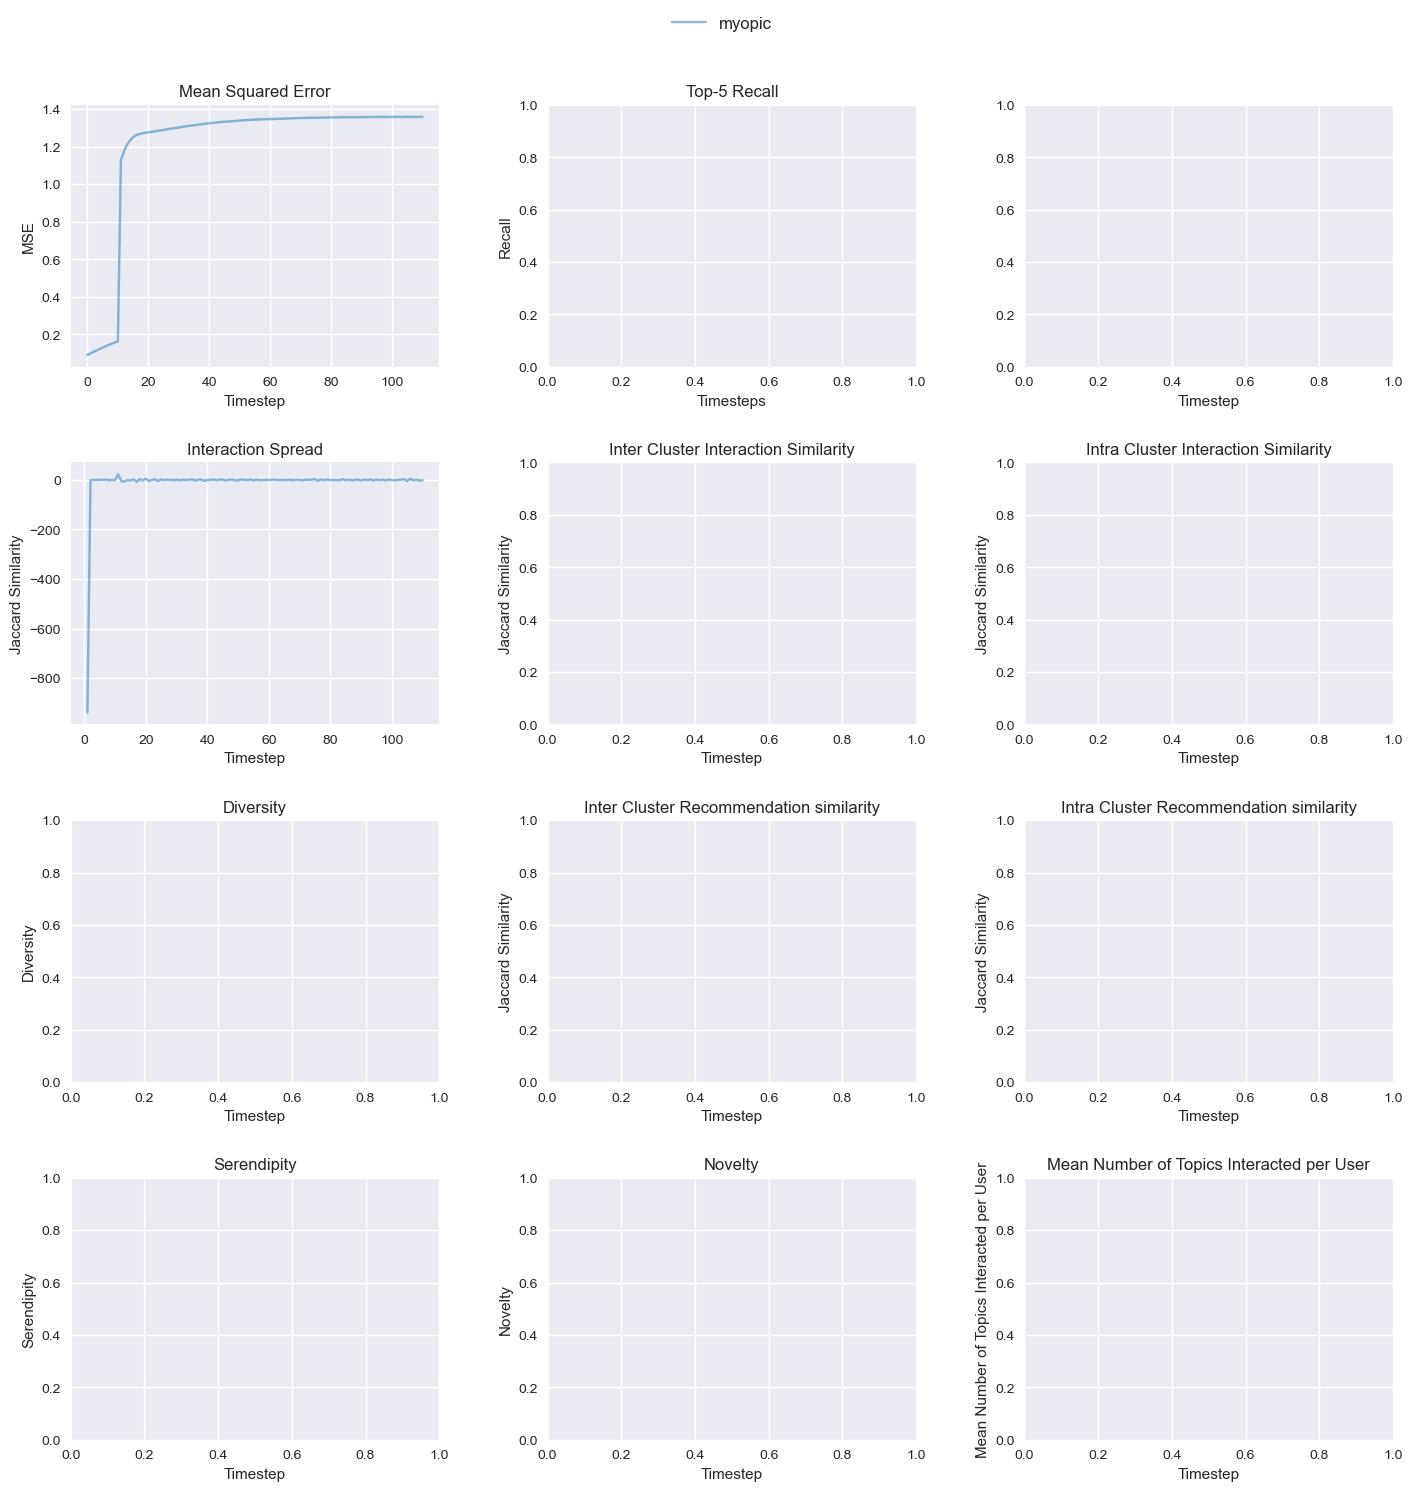

In [23]:
plot_measurements([measurements_df], parameters_df)

In [56]:
plt.plot(measurements_df['mse'], label='mse', alpha=0.5)

(100,)


[24113,
 20629,
 18909,
 18042,
 17567,
 17087,
 16812,
 16752,
 16711,
 16746,
 16652,
 16420,
 16163,
 15996,
 15686,
 15310,
 15012,
 14531,
 14155,
 13688,
 13219,
 12700,
 12214,
 11741,
 11281,
 10840,
 10230,
 9778,
 9279,
 8879,
 8390,
 7978,
 7624,
 7202,
 6803,
 6476,
 6282,
 5943,
 5581,
 5215,
 4930,
 4727,
 4462,
 4236,
 3996,
 3713,
 3525,
 3321,
 3132,
 2984,
 2827,
 2665,
 2514,
 2414,
 2286,
 2194,
 2080,
 1967,
 1862,
 1731,
 1647,
 1574,
 1499,
 1400,
 1320,
 1276,
 1224,
 1177,
 1144,
 1099,
 1067,
 1033,
 1012,
 982,
 962,
 932,
 913,
 891,
 874,
 850,
 829,
 795,
 786,
 768,
 755,
 744,
 721,
 715,
 704,
 694,
 687,
 683,
 667,
 660,
 651,
 646,
 637,
 629,
 624,
 620]

# Experiments

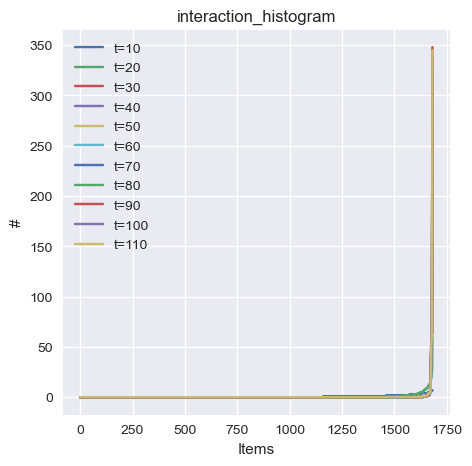

In [25]:
def plot_histograms(measurements_df, column_name):
    # for every 10 timesteps plot line in different color
    fig= plt.figure(figsize=(5, 5))
    
    timesteps = len(measurements_df)
    items = np.arange(len(measurements_df[column_name][1]))
    for i in range(10, timesteps+1, 10):
        counts = measurements_df[column_name][i]
        plt.plot(items, sorted(counts), label=f't={i}')

    plt.title(column_name)
    plt.xlabel('Items')
    plt.ylabel('#')
    plt.legend()
    
plot_histograms(measurements_df, 'interaction_histogram')

[  0  10  20  30  40  50  60  70  80  90 100]


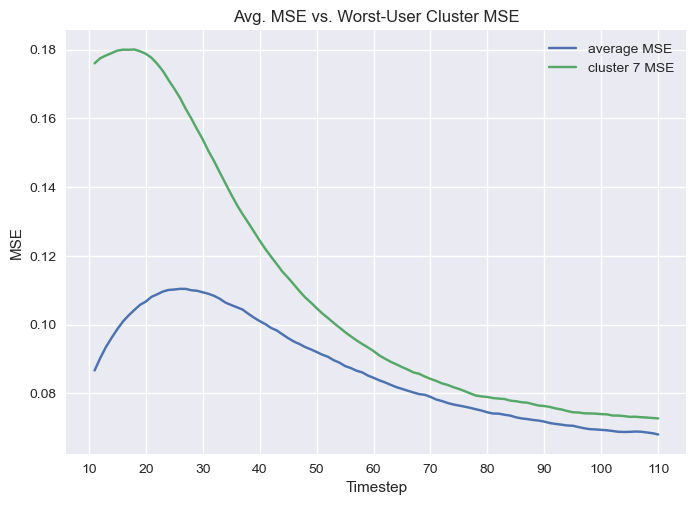

In [26]:
# df_user_mse = pd.DataFrame(user_mse)
# df_user_mse['clusterID'] = user_cluster_ids
import src
reload(src.utils)
from src.utils import *
df_user_mse = pd.read_csv(path_user_mse_histogram)
analyze_user_mse(df_user_mse, train_timesteps)

In [27]:
print(this_experiment)

cosine_sim2_0.01_retrainTrue


In [28]:
def test_cosine_sim2(predicted_user_profiles, predicted_item_attributes):
    """
    Calculate cosine similarity for each user, item pair.
    """
    alpha = 0
    print(alpha)
        
    denominator = np.outer(np.linalg.norm(predicted_user_profiles, axis=1), np.linalg.norm(predicted_item_attributes, axis=0))
    # cosine similarity is equal to inner product, divided by the norm of the user & item vector
    numerator = np.dot(predicted_user_profiles, predicted_item_attributes)
    cos_sim = numerator / denominator
    penalty = numerator - alpha*cos_sim
    
    print(cos_sim.shape)
    print(cos_sim)
    
    re_ranked_scores = penalty + np.abs(np.min(penalty, axis=1))[:, np.newaxis]

    assert(not np.any(re_ranked_scores < 0))
        
    return re_ranked_scores

x = test_cosine_sim2(user_representation, user_representation.T)
x.shape

0
(943, 943)
[[1.         0.06077216 0.09558311 ... 0.24760241 0.21717411 0.61936789]
 [0.06077216 1.         0.50441562 ... 0.42162757 0.19306238 0.06231327]
 [0.09558311 0.50441562 1.         ... 0.14191328 0.46759632 0.0229938 ]
 ...
 [0.24760241 0.42162757 0.14191328 ... 1.         0.03023909 0.02176969]
 [0.21717411 0.19306238 0.46759632 ... 0.03023909 1.         0.26009879]
 [0.61936789 0.06231327 0.0229938  ... 0.02176969 0.26009879 1.        ]]


(943, 943)